# 1. 기본 설정

In [ ]:
# jupyter notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 한글폰트
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

# Spark
params=[('spark.yarn.queue')]
session = JupyterSparkSession(params=params).session

bash: /root/utils/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)


23/02/09 16:15:27 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 2. 데이터 분석
**목표**
+  **2020년 12월 ~2022년 12월 데이터를 이용해, 2023년 월별 페이지뷰의 모평균 신뢰구간 구하기**

\
목표 구현 순서
1. 일별 데이터를 이용한 일별 페이지뷰 예측 모델 구축 (선형회귀모형)
2. 일별 모형을 이용한 월별 페이지뷰 신뢰구간 구축

## 2.1. 데이터 가져오기
+ row : 날짜
+ column : 설명변수(517여개)


In [ ]:
# pivot df 바로 가져오기
from datetime import datetime
import pandas as pd
pivot_df = pd.read_csv('pivot_df_prediction.csv')
pivot_df['date_id'] = pivot_df['date_id'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
pivot_df.index = pivot_df['date_id']
pivot_df

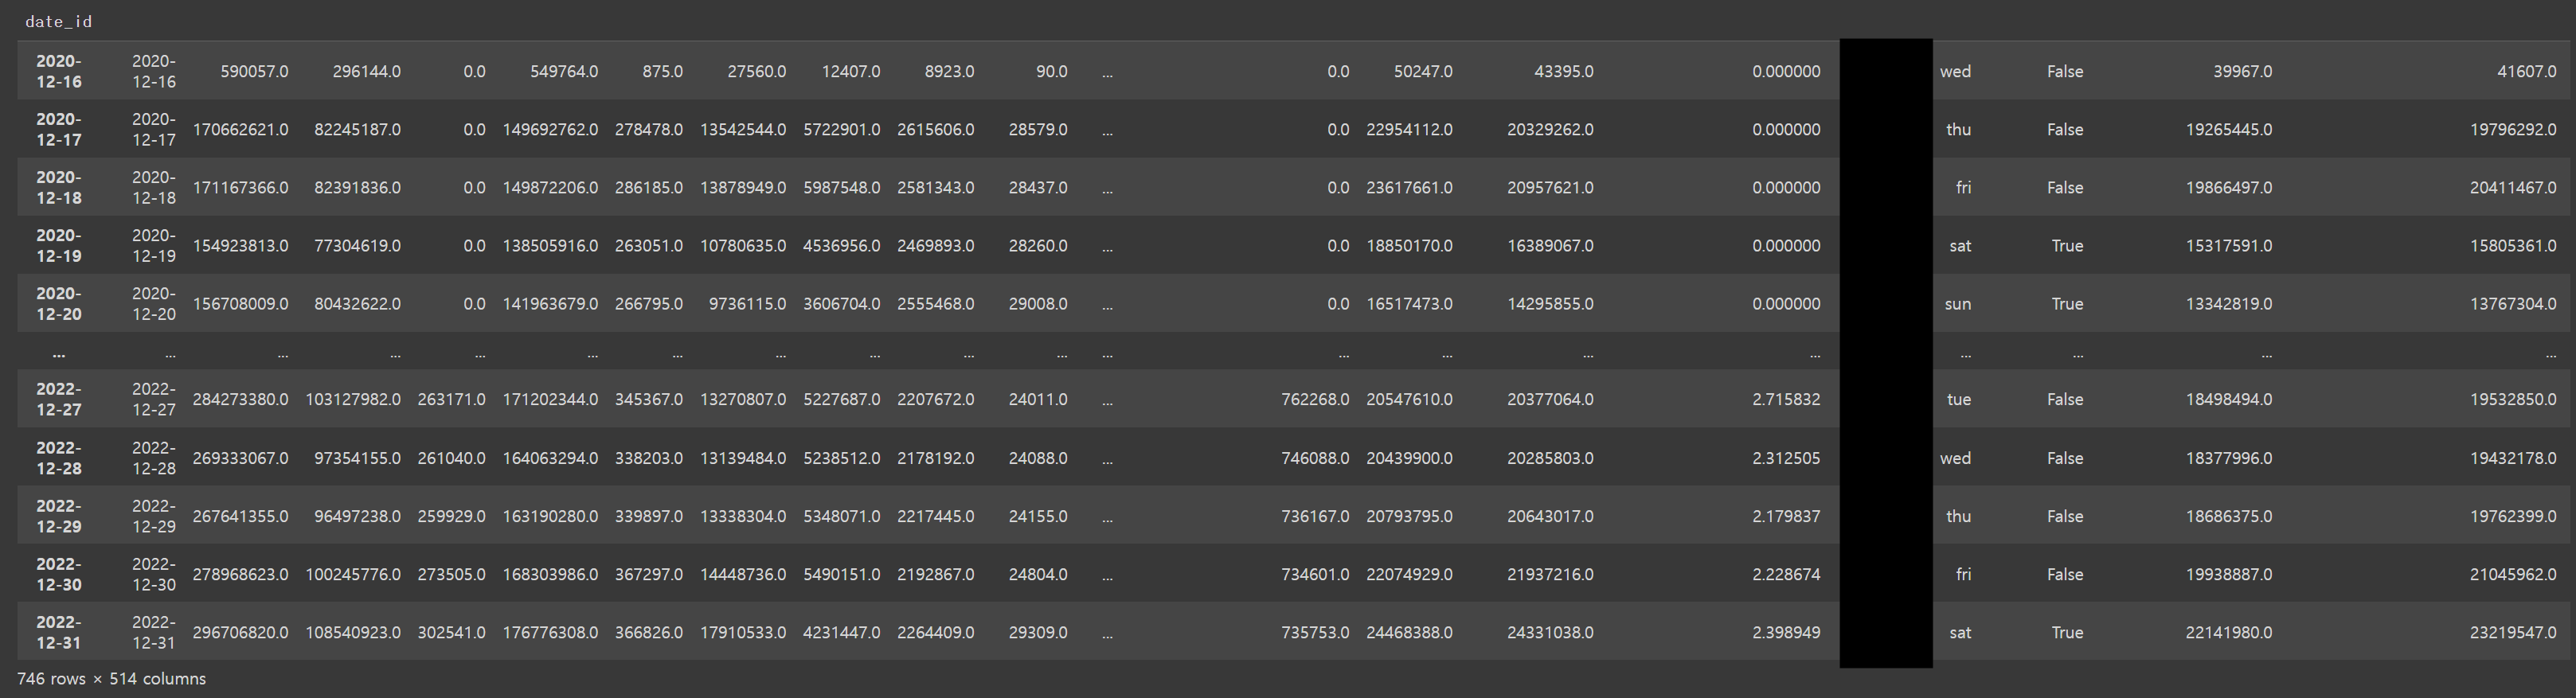

## 2.2. 함수 작성
+ 목표 달성을 위한 함수들 작성


### 2.2.1 데이터 선별


+ `make_xy_new()` : x_code에 해당하는 설명변수 선택 & 이상치 있는 데이터 구간 삭제 후 반환
+ `get_test_xy()` : 테스트 데이터 반환
+ `get_train_xy()` : 훈련 데이터 반환





In [ ]:
def make_xy_new(pivot_df, x_code):
    # 2020년 12월~ 2022년 12월 데이터 중 이상치가 있는 기간의 데이터 제외
    x1 = np.array(pivot_df.loc['2021-09-22':'2021-12-30',x_code])
    x2 = np.array(pivot_df.loc['2022-01-02':'2022-05-01',x_code])
    x3 = np.array(pivot_df.loc['2022-05-25':'2022-10-14',x_code])
    x4 = np.array(pivot_df.loc['2022-10-18':'2022-12-30',x_code])
    x = np.vstack([x1,x2,x3,x4])
    
    y1 = np.array(pivot_df.loc['2021-09-22':'2021-12-30','target_y'])
    y2 = np.array(pivot_df.loc['2022-01-02':'2022-05-01','target_y'])
    y3 = np.array(pivot_df.loc['2022-05-25':'2022-10-14','target_y'])
    y4 = np.array(pivot_df.loc['2022-10-18':'2022-12-30','target_y'])
    y = np.vstack([y1.reshape(-1,1),y2.reshape(-1,1),y3.reshape(-1,1), y4.reshape(-1,1)]).reshape(-1)
    
    return x, y


def get_test_xy(target_start, target_end, x_code):
    x , y = make_xy_new(pivot_df[(pivot_df.date_id>=target_start)&(pivot_df.date_id<target_end)], x_code)
    return x, y

def get_train_xy(target_start, target_end, x_code):
    x , y = make_xy_new(pivot_df[(pivot_df.date_id>='2021-11-01')&(~((pivot_df.date_id>=target_start)&(pivot_df.date_id<target_end)))], x_code)
    return x, y

### 2.2.2 데이터 표준화
선형회귀모형에 데이터를 활용하기 위해 표준화 진행

+ `normalization()` : 훈련 데이터의 각 column의  $\mu$(평균), $s$(표준편차) 값 이용해 훈련 데이터 표준화 후, 해당 $\mu, s$ 값 이용하여 테스트 데이터 값 표준화

In [ ]:
def normalization(x_train, y_train, x_test, y_test):
    mean_std_dict = {}

    ## train
    for i in range(x_train.shape[1]):
        m = x_train[:,i].mean()
        s=x_train[:,i].std()
        x_train[:,i] = (x_train[:,i] - m)/s
        mean_std_dict[i] = [m,s]

    m = y_train.mean()
    s= y_train.std()
    y_train = (y_train - m)/s
    mean_std_dict['y'] = [m,s]


    ## test
    for i in range(x_test.shape[1]):
        m ,s = mean_std_dict[i]
        x_test[:,i] = (x_test[:,i] - m)/s

    m,s = mean_std_dict['y']
    y_test = (y_test - m)/s

    print(mean_std_dict)
    
    return x_train, y_train, x_test, y_test, mean_std_dict

### 2.2.3. 월간 페이지뷰(y) 모평균 신뢰구간 구하기 (기존 데이터로 train & test)
훈련데이터를 이용해 선형회귀모형을 적합하고, `테스트 데이터 전체 합(월간 페이지뷰)`의 모평균 신뢰구간 구하기


+ `get_ci()` : 적합된 선형회귀 모형 `reg` 를 이용해, `x_test` 기간 전체의 `y값 합의 모평균 신뢰구간`을 구한 후, 실제 해당 테스트 기간(1 month)의 값이 신뢰구간에 들어가는지 파악

**목표**
+ [2] 월간 페이지뷰의 모평균에 대한 신뢰구간 구축

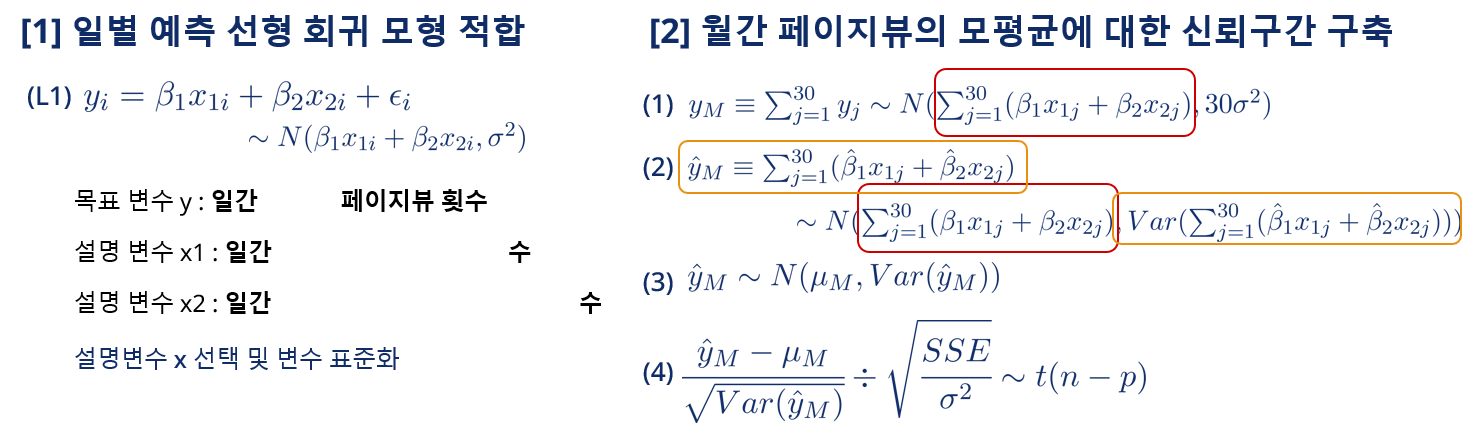

위의 이미지에서 [1]의 모델 (L1) 을 이용해서 [2]의 월간 페이지뷰의 모평균에 대한 신뢰구간을 구축

**구축과정**
1. [2] 에서 (1) 식의 빨간 박스인 모평균에 대한 신뢰구간을 구하고자 함
2. 1.을 위해 모델 (L1)을 이용해 식 (2)의 주황 박스 부분을 구함 & 식(2)를 간편하게 식(3)으로 나타냄
3. (2) 에서 주황박스(관측치 & 분산)을 구했으니, (4)를 이용해서 모평균 $\mu_M $대한 신뢰구간을 구할 수 있음

In [ ]:
def get_ci(reg, x_train, x_test, y_test_non_normal, mean_std_dict, point_ci=False):
    
    # y 합들의 표준편차 추정하기 = s 구하기
    
    ## 계산에필요한 기본 값들
    sse = ((reg.resid)**2).sum()
    Xm = x_test                         # 30 x p
    X = x_train
   
    ## matrix product : np.dot(A,B)
    XtX_inv = np.linalg.inv(np.dot(X.T,X))
    
    ## y 합들의 표준편차에 대한 추정값
    s = np.sqrt(( np.dot(np.dot(Xm, XtX_inv), Xm.T).sum() ) * sse)
    if point_ci == True:  # 예측 값 신뢰구간 구하는 경우
        s = np.sqrt(( np.dot(np.dot(Xm, XtX_inv), Xm.T).sum() + x_test.shape[0] ) * sse) 
    
    
    #신뢰구간
    from scipy.stats import t
    ## t분포 값
    alpha = 0.05
    d_freedom = X.shape[0] - X.shape[1]  # n-p
    t_critical = (-1)*t.ppf(alpha/2, d_freedom)
    
    ## 구간값
    beta_hat = reg.params.reshape(Xm.shape[1],1)  # p x 1
    point_estimate = np.dot(Xm, beta_hat).sum()
    print(f'debug : point_estimate : {point_estimate},  s :{s} ')
    left_ci = point_estimate - t_critical*s
    right_ci = point_estimate + t_critical*s

    ## 신뢰구간 변환
    point_estimate_new = point_estimate*mean_std_dict['y'][1] + mean_std_dict['y'][0]*Xm.shape[0]
    left_ci_new = left_ci*mean_std_dict['y'][1] + mean_std_dict['y'][0]*Xm.shape[0]
    right_ci_new = right_ci*mean_std_dict['y'][1] + mean_std_dict['y'][0]*Xm.shape[0]

    
    print('신뢰구간 : ',left_ci_new, right_ci_new)
    in_ci = False
    if (y_test_non_normal.sum() >= left_ci_new) & (y_test_non_normal.sum() <= right_ci_new):
        in_ci = True
    print(f'실제 값 합인 {y_test_non_normal.sum()} 은 신뢰구간에 들어갈까? {in_ci}')
    
    left_ci_new = round(left_ci_new/100000000,4)
    right_ci_new = round(right_ci_new/100000000,4)
    point_estimate_new = round(point_estimate_new/100000000,4)
    return left_ci_new, right_ci_new, right_ci_new - left_ci_new, point_estimate_new

### 2.2.4. 미래의 `월별 페이지뷰 모평균 신뢰구간` 구축
+ 2.2.3. 을 이용하여 해당 방식이 기존 데이터로 잘 작동하는 것을 확인 후, 2023년 월간 페이지뷰 모평균 신뢰구간 예측을 위해 사용하는 코드

In [ ]:
# test y 없는 경우 예측!
def get_predict_ci(reg, x_train, x_test, mean_std_dict):
    # y 합들의 표준편차 추정하기 = s 구하기
    
    ## 계산에필요한 기본 값들
    sse = ((reg.resid)**2).sum()
    Xm = x_test                         # 30 x p
    X = x_train
   
    ## matrix product : np.dot(A,B)
    XtX_inv = np.linalg.inv(np.dot(X.T,X))
    
    
    ## y 합들의 표준편차에 대한 추정값
    s = np.sqrt(( np.dot(np.dot(Xm, XtX_inv), Xm.T).sum() ) * sse)
#     print(f'debug :  예측 y들의 분산 합 : np.dot(np.dot(Xm, XtX_inv), Xm.T) = { (np.dot(np.dot(Xm, XtX_inv), Xm.T)).sum()}')
    
    # 신뢰구간
    from scipy.stats import t
    # t분포 값
    alpha = 0.05
    d_freedom = X.shape[0] - X.shape[1]  # n-p
    t_critical = (-1)*t.ppf(alpha/2, d_freedom)
    
    ## 구간값
    beta_hat = reg.params.reshape(Xm.shape[1],1)  # p x 1
    point_estimate = np.dot(Xm, beta_hat).sum()
#     print(f'debug : point_estimate : {point_estimate},  s :{s} ')
    left_ci = point_estimate - t_critical*s
    right_ci = point_estimate + t_critical*s

    ## 신뢰구간 변환
    point_estimate_new = point_estimate*mean_std_dict['y'][1] + mean_std_dict['y'][0]*Xm.shape[0]
    left_ci_new = left_ci*mean_std_dict['y'][1] + mean_std_dict['y'][0]*Xm.shape[0]
    right_ci_new = right_ci*mean_std_dict['y'][1] + mean_std_dict['y'][0]*Xm.shape[0]
    left_ci_new = round(left_ci_new/100000000,4)
    right_ci_new = round(right_ci_new/100000000,4)
    point_estimate_new = round(point_estimate_new/100000000,4)
#     print('신뢰구간 : ',left_ci_new, right_ci_new)
    return left_ci_new, right_ci_new, right_ci_new - left_ci_new, point_estimate_new

## 2.3. 모델 성능 테스트
1. 선택한 설명변수를 이용한 선형회귀모형이 잘 적합되는지 확인

2. 기존 데이터 값인 2020년 12월 ~ 2022년 12월의 값을 이용해서, 각 월의 y값에 대한 신뢰구간 구축이 잘 되는지 확인


### 2.3.1. 선형회귀모형의 적합정도 확인
+ 2022년 6월 경우의 플랏으로 이외의 모든 월(month)에서 잘 작동함

(367, 2) (367,) (30, 2) (30,)
{0: [18905745.3760218, 2366764.3327069962], 1: [1953875.6348773842, 192563.00430682552], 'y': [233298063.0653951, 17477798.16919697]}
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              817.7
Date:                Wed, 15 Feb 2023   Prob (F-statistic):                   1.46e-135
Time:                        11:58:01   Log-Likelihood:                         -208.58
No. Observations:                 367   AIC:                                      421.2
Df Residuals:                     365   BIC:                                      429.0
Df Model:                           2                                                  
Covariance Type:            nonrobust       

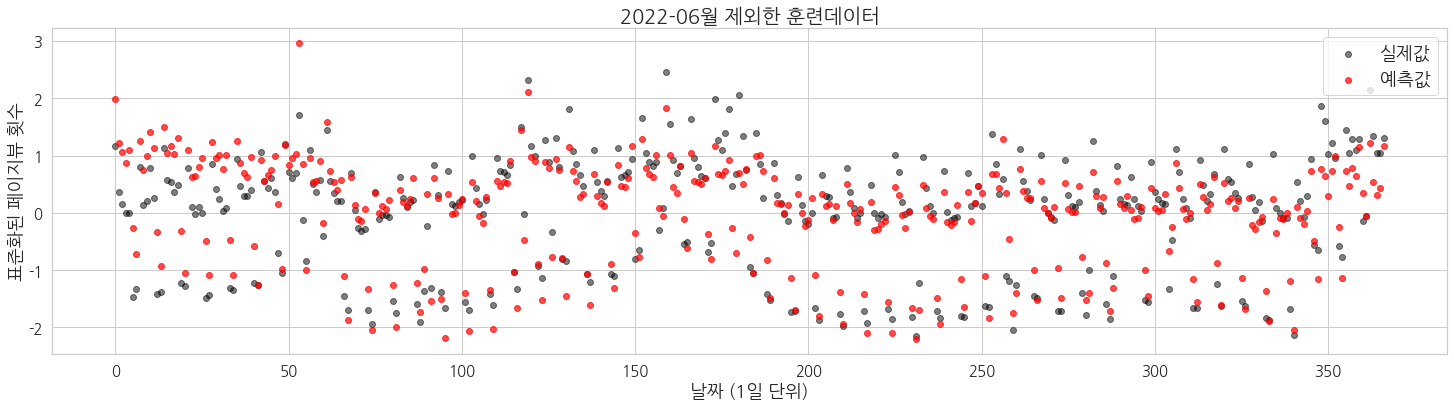

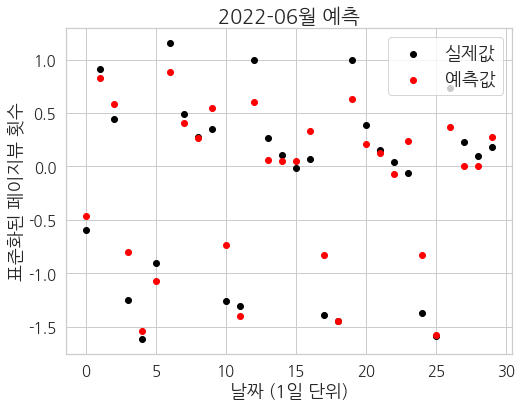

Text(0.5, 1.0, '표준화된 잔차의 Q-Q Plot')

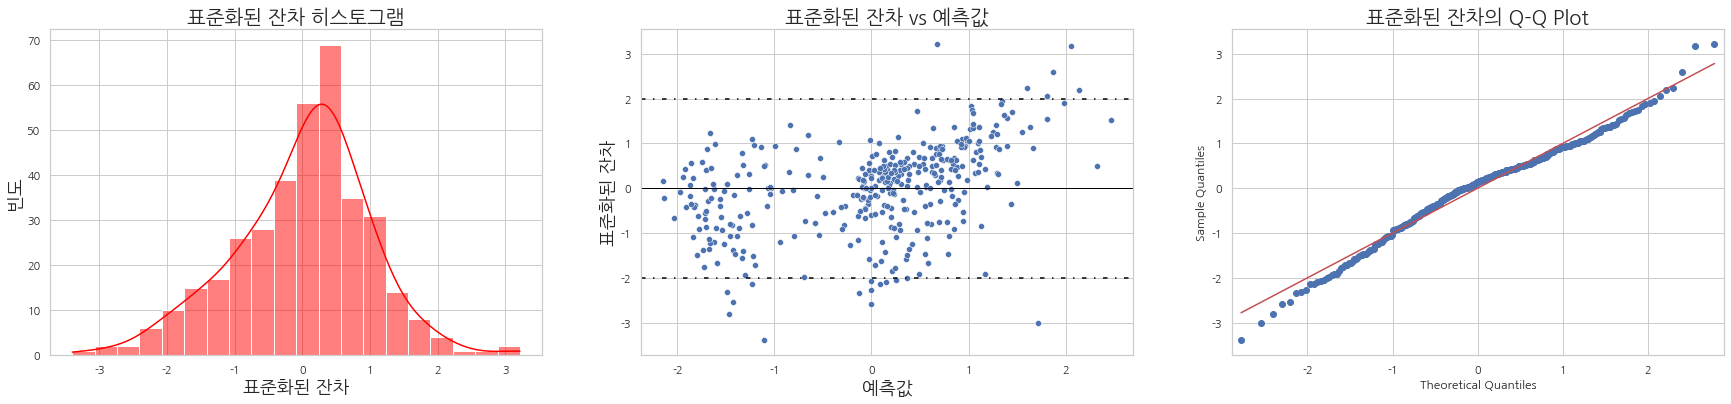

In [ ]:
# 적합플랏보기
import statsmodels.api as sm

target_start = '2022-06-01'
target_end   = str(datetime(int(target_start.split('-')[0]),int(target_start.split('-')[1]),int(target_start.split('-')[2])) + relativedelta(months=1))[:10]
x_code = ['설명변수1', '설명변수2']

x_train, y_train = get_train_xy(target_start,target_end, x_code)
x_test, y_test   = get_test_xy(target_start,target_end, x_code)
print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

y_test_non_normal = y_test.copy()


## normalize
x_train, y_train, x_test, y_test, mean_std_dict = normalization(x_train, y_train, x_test, y_test)


# 적합
reg = sm.OLS(y_train, x_train).fit()
print(reg.summary())
print('-'*100)
get_ci(reg, x_train, x_test, y_test_non_normal, mean_std_dict)
print('-'*100)




# 폰트
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'


# 적합값
plt.figure(figsize=(25,6))
plt.title(f'{target_start[:7]}월 제외한 훈련데이터', fontsize=20)
plt.scatter(range(x_train.shape[0]),y_train, c='black', label='실제값')
plt.scatter(range(x_train.shape[0]),reg.predict(x_train), c='red', label='예측값')
plt.legend(fontsize=18, loc='upper right')
plt.ylabel('표준화된 페이지뷰 횟수', fontsize=18)
plt.yticks(fontsize=15)
plt.xlabel('날짜 (1일 단위)', fontsize=18)
plt.xticks(fontsize=15)
plt.show()

# 예측값
plt.figure(figsize=(8,6))
plt.title(f'{target_start[:7]}월 예측', fontsize=20)
plt.scatter(range(x_test.shape[0]),y_test, c='black', label='실제값')
plt.scatter(range(x_test.shape[0]),reg.predict(x_test), c='red', label='예측값')
plt.legend(fontsize=18, loc='upper right')
plt.ylabel('표준화된 페이지뷰 횟수', fontsize=18)
plt.yticks(fontsize=15)
plt.xlabel('날짜 (1일 단위)', fontsize=18)
plt.xticks(fontsize=15)
plt.show()



# 잔차
from statsmodels.stats.outliers_influence import OLSInfluence
## Get internally studentized residuals
influence = OLSInfluence(reg)
internally_studentized_resid = influence.resid_studentized_internal

fig, axs = plt.subplots(1,3,figsize=(30,6))
## 1. internally residual histogram
sns.set(style='whitegrid')
sns.histplot(internally_studentized_resid, kde=True, color='red',ax=axs[0])
axs[0].set_xlabel('표준화된 잔차', fontsize=18)
axs[0].set_ylabel('빈도', fontsize=18)
axs[0].set_title('표준화된 잔차 히스토그램', fontsize=20)

## 2. residual plot
residual_data = pd.DataFrame({'Predicted Values': y_train.reshape(len(y_train),), 'internally_studentized_resid': internally_studentized_resid.reshape(len(internally_studentized_resid),)}, index=list(range(len(internally_studentized_resid))))
sns.scatterplot(x='Predicted Values', y='internally_studentized_resid', data=residual_data, ax=axs[1])
axs[1].set_xlabel('예측값',fontsize=18)
axs[1].set_ylabel('표준화된 잔차', fontsize=18)
axs[1].set_title('표준화된 잔차 vs 예측값', fontsize=20)
axs[1].axhline(y=0, color='black', lw=1)
axs[1].axhline(y=2, color='black', linestyle=(0, (3, 5, 1, 5)))
axs[1].axhline(y=-2, color='black', linestyle=(0, (3, 5, 1, 5)))


## 3. qq
sm.qqplot(internally_studentized_resid, line='s', ax=axs[2])
axs[2].set_title('표준화된 잔차의 Q-Q Plot', fontsize=20)




### 2.3.2. 월별 페이지뷰 값 예측 + 월별 페이지뷰 모평균 신뢰구간

In [ ]:
# 월별 신뢰구간 - 예측할 때 이상치 제외한 test set 그대로 활용
result_df = pd.DataFrame(columns=['test_month','설명변수1','설명변수2','left_ci','right_ci','ci_length','예측값','실제값'])
test_month = ['2021-11-01','2021-12-01','2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01']
for target_start in test_month:
    target_end   = str(datetime(int(target_start.split('-')[0]),int(target_start.split('-')[1]),int(target_start.split('-')[2])) + relativedelta(months=1))[:10]
#     print(target_start, target_end)
    x_code = ['설명변수1', '설명변수2']

    x_train, y_train = get_train_xy(target_start,target_end, x_code)
    x_test, y_test   = get_test_xy(target_start,target_end, x_code)
    print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)


    y_test_non_normal = y_test.copy()


    ## normalize
    x_train, y_train, x_test, y_test, mean_std_dict = normalization(x_train, y_train, x_test, y_test)


    # 적합
    reg = sm.OLS(y_train, x_train).fit()
#     print(reg.summary())
    print('-'*100)
    print(target_start, f' 예측일수 : {len(y_test)}')
    left_ci, right_ci, ci_length , point_estimate = get_ci(reg, x_train, x_test, y_test_non_normal, mean_std_dict, point_ci=True) # 1년 후 증가했을 거라 가정 시 신뢰구간
    print('-'*100)
    x1_ratio, x2_ratio = 1, 1
    result_df.loc[len(result_df)] = [target_start, x1_ratio, x2_ratio,left_ci, right_ci, ci_length, point_estimate, round(y_test_non_normal.sum()/100000000,4)]



(367, 2) (367,) (30, 2) (30,)
{0: [18768601.798365124, 2317480.3490770264], 1: [1946871.438692098, 191849.2559072332], 'y': [233152177.21525887, 17495807.91805132]}
----------------------------------------------------------------------------------------------------
2021-11-01  예측일수 : 30
debug : point_estimate : 22.211827826352682,  s :39.98788713616996 
신뢰구간 :  6007386464.684 8758971914.54892
실제 값 합인 6966516926.0 은 신뢰구간에 들어갈까? True
----------------------------------------------------------------------------------------------------
(367, 2) (367,) (30, 2) (30,)
{0: [18804542.367847413, 2331169.5037324904], 1: [1941749.6675749319, 182187.88962729825], 'y': [232808090.35422343, 17532091.599310473]}
----------------------------------------------------------------------------------------------------
2021-12-01  예측일수 : 30
debug : point_estimate : 19.620435840335475,  s :43.852744535201225 
신뢰구간 :  5816336979.817529 8840122998.178188
실제 값 합인 7092796804.0 은 신뢰구간에 들어갈까? True
-------------------

### 2.3.3.월별 페이지뷰 모평균 신뢰구간 시각화
+ 잘 맞는 것을 확인할 수 있음

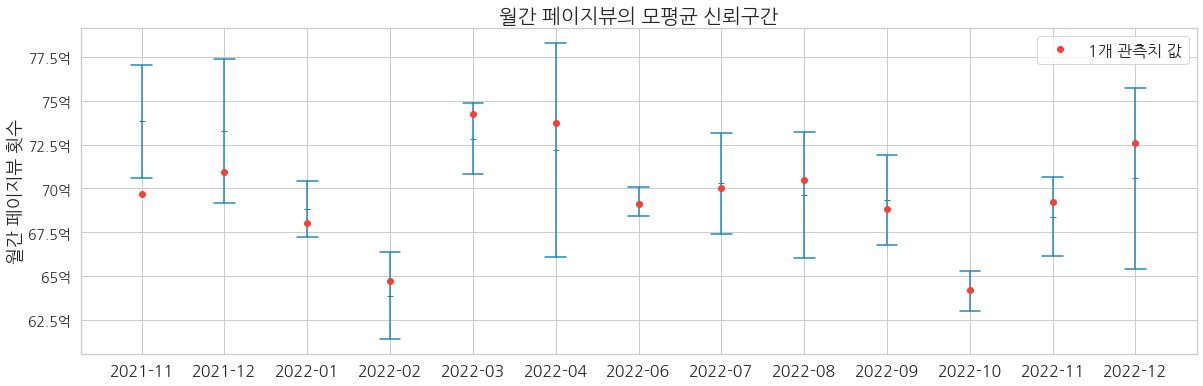

In [ ]:
# ci
import matplotlib.pyplot as plt
import statistics
from math import sqrt

# 한글폰트
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

def plot_confidence_interval(x, top, bottom, mean, true_mean, label=False, color='#2187bb', horizontal_line_width=0.25):


    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, '_', color=color)
    
    if label == True:
        plt.plot(x, true_mean, 'o', color='#f44336', label='1개 관측치 값')
    else:
        plt.plot(x, true_mean, 'o', color='#f44336' )
    return


plt.figure(figsize=(20,6))
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12], ['2021-11', '2021-12', '2022-01', '2022-02', '2022-03','2022-04','2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12'], fontsize=16)
plt.title('월간 페이지뷰의 모평균 신뢰구간', fontsize=20)
plt.yticks([60,62.5,65,67.5,70,72.5,75,77.5,80],['60억','62.5억','65억','67.5억','70억','72.5억','75억','77.5억','80억'],fontsize=14)
plt.ylabel('월간 페이지뷰 횟수', fontsize=18)
for i in range(len(result_df2)):
    label=False
    if i == 0:
        label = True
    plot_confidence_interval(i, result_df2.loc[i, 'right_ci'], result_df2.loc[i, 'left_ci'], result_df2.loc[i, '예측값'],result_df2.loc[i, '실제값'], label)

plt.legend(loc='upper right', fontsize=16)
plt.show()

## 2.4. 2023년 월별 페이지뷰 신뢰구간 구축 & 시각화

### 2.4.1. 2023년 월별 페이지뷰 신뢰구간 수치계산

In [ ]:
# 2023년 미래의 설명변수 조정 후 예측!!!
import pandas as pd
from itertools import product
from tqdm import tqdm

result_df = pd.DataFrame(columns=['test_month','설명변수1','설명변수2','left_ci','right_ci','ci_length','예측값','기존설명변수1_횟수(day)', '필요한설명변수1_횟수(day)','기존설명변수2_횟수(day)','필요한설명변수2_횟수(day)'])
ratio = [1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7]



x_code = ['설명변수1', '설명변수2']
x , y = make_xy_new(pivot_df[(pivot_df.date_id>='2021-11-01')], x_code)



# normalize
mean_std_dict = {}
for i in range(x.shape[1]):
    m = x[:,i].mean()
    s=x[:,i].std()
    x[:,i] = (x[:,i] - m)/s
    mean_std_dict[i] = [m,s]

m = y.mean()
s= y.std()
y = (y - m)/s
mean_std_dict['y'] = [m,s]

# 적합
reg = sm.OLS(y, x).fit()

beta1, beta2 = reg.params
print('beta 값 : ', beta1, beta2)
up_count = 1000000
# x1 10000회
x1 = (up_count -mean_std_dict[0][0])/mean_std_dict[0][1]
delta_y1_normal = beta1 * x1
y1 = delta_y1_normal*mean_std_dict['y'][1] + mean_std_dict['y'][0]

x2 = (up_count -mean_std_dict[1][0])/mean_std_dict[1][1]
delta_y2_normal = beta2 * x2
y2 = delta_y2_normal*mean_std_dict['y'][1] + mean_std_dict['y'][0]
print('표준화 된 y 값',delta_y1_normal, delta_y2_normal)
print('y dictionary : m, s = ',mean_std_dict['y'])
print(f'설명변수1 {up_count}회 증가시 페이지뷰 {y1}회 증가')
print(f'설명변수2 {up_count}회 증가시 페이지뷰 {y2}회 증가')


for x1_ratio, x2_ratio in tqdm(zip(ratio, ratio)):
    test_month = ['2021-11-01','2021-12-01','2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01']
    for target_start in test_month:
        target_start_month_end = str(datetime(int(target_start.split('-')[0]),int(target_start.split('-')[1]),int(target_start.split('-')[2])) + relativedelta(months=1) - timedelta(days=1))[:10]
        target_end   = str(datetime(int(target_start.split('-')[0]),int(target_start.split('-')[1]),int(target_start.split('-')[2])) + relativedelta(months=1))[:10]
        

        # 예측할 x 값 가져오기
        x_test = np.array(pivot_df.loc[target_start:target_start_month_end, x_code])
        y_test = pivot_df.loc[target_start:target_start_month_end, 'target_y']
        x_test_origin = x_test.copy()

        ## 설명변수 x값 증가
        x1_up = x1_ratio
        x2_up = x2_ratio
        up_x_test = x_test.copy()
        up_x_test[:,0] = up_x_test[:,0]*x1_up
        up_x_test[:,1] = up_x_test[:,1]*x2_up

        ## 표준화
        for i in range(x_test.shape[1]):
            m ,s = mean_std_dict[i]
            x_test[:,i] = (x_test[:,i] - m)/s
            up_x_test[:,i] = (up_x_test[:,i] - m)/s




        # 예측 ci 구하기
#         print('-'*100)
#         print(target_start, f' 예측일수 : {x_test.shape[0]}, 참값 : {y_test.sum()}')
        get_predict_ci(reg, x, x_test, mean_std_dict)   # 기존값
#         print()
        left_ci, right_ci, ci_length , point_estimate  = get_predict_ci(reg, x, up_x_test, mean_std_dict) # 1년 후 증가했을 거라 가정 시 신뢰구간
#         print('-'*100)
        result_df.loc[len(result_df)] = [target_start, x1_ratio, x2_ratio,left_ci, right_ci, ci_length, point_estimate, x_test_origin[:,0].mean(),x_test_origin[:,0].mean()*(x1_ratio-1)/10000, x_test_origin[:,1].mean(), x_test_origin[:,1].mean()*(x2_ratio-1)/10000]




위 코드 실행 시 나오는 수치 값

```
beta 값 :  0.9257845636882684 0.2822047822107271
표준화 된 y 값 -7.037624081450496 -1.4223719096469187
y dictionary : m, s =  [233081526.35768262, 17316237.320136093]
설명변수1 1000000회 증가시 페이지뷰 111216357.59338105회 증가
설명변수2 1000000회 증가시 페이지뷰 208451396.8127414회 증가

```

### 2.4.2. 신뢰구간의 길이가 적정한지 파악
+ 신뢰구간 길이가 20억 미만이고, 값이 적절한 것(=70억 이상) 찾기

In [ ]:
result_df[(result_df.ci_length<20)&(result_df.right_ci>=70)]
result_df.sort_values('ci_length').head(30)

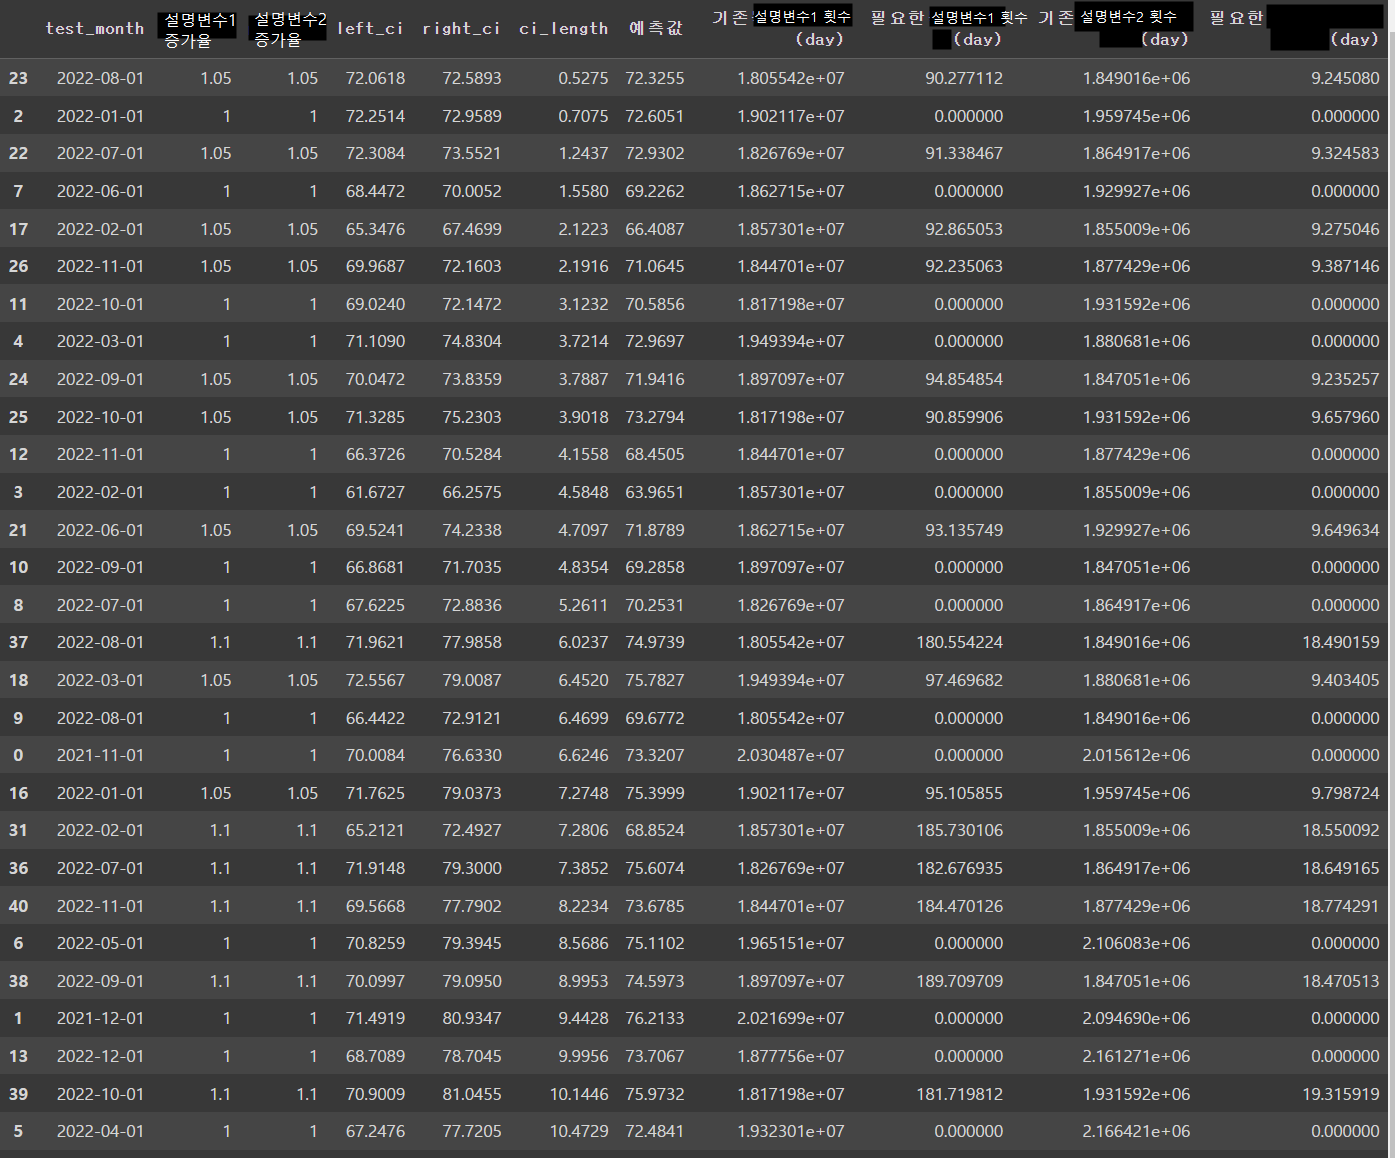

###2.4.3. 2023년 페이지뷰 신뢰구간 시각화

In [ ]:
# ci

import matplotlib.pyplot as plt
import statistics
from math import sqrt

# 한글폰트
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

def plot_confidence_interval(x, top, bottom, mean,label, color='#2187bb', horizontal_line_width=0.25):


    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    
    
    if label == True:
        plt.plot(x, mean, 'x', color=color)#, label='모평균에 대한 점추정치')
    else:
        plt.plot(x, mean, 'x', color=color)

    return



ratio_lst = [1,1.05,1.1,1.15,1.2,1.25,1.3]
def show_month_ci(test_month, result_df, ratio_lst):

    plt.figure(figsize=(20,6))
    xtick_lst = [str(ratio) + '배' for ratio in ratio_lst]
    plt.xticks(range(len(ratio_lst)), xtick_lst, fontsize=16)
    plt.xlabel(f'{test_month[:7]}월 대비 설명변수1과 설명변수2의 횟수 증가율', fontsize=18)
    plt.title(f'2023년 {test_month[5:7]}월 페이지뷰의 모평균 신뢰구간', fontsize=20)
    y_tick = [40,50,60,70,80,90,100,110,120]
    y_tick_name = [str(x)+'억' for x in y_tick]
#     plt.yticks([40,45, 50,55,60,65,70,75,80,85,90,95,100,105,110,115,120],['40억','45억','50억','55억','60억','65억','70억','75억','80억','85억','90억','95억','100억','105억','110억','115억','120억'],fontsize=14)
    plt.yticks(y_tick, y_tick_name, fontsize=14)
    plt.ylabel(f'월간 페이지뷰 횟수', fontsize=18)
    plt.axhline(100, color='red', linestyle=(0, (3, 5, 1, 5)), label='100억회')
#     plt.axhline(90, color='gray', linestyle=(0, (3, 5, 1, 5)))
#     plt.axhline(80, color='gray', linestyle=(0, (3, 5, 1, 5)))
    plt.ylim(60,120)
    for i in range(len(ratio_lst)):
        result_df2 = result_df[(result_df['test_month']==test_month)&(result_df['x1'].isin([1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]))].sort_values('x1').reset_index(drop=True)
        if i!= 0:
            plot_confidence_interval(i, result_df2.loc[i, 'right_ci'], result_df2.loc[i, 'left_ci'], result_df2.loc[i, '예측값'], label=False)
        else:
            plot_confidence_interval(i, result_df2.loc[i, 'right_ci'], result_df2.loc[i, 'left_ci'], result_df2.loc[i, '예측값'], label=True)
        x = list(range(len(ratio_lst)))[i]
        y = result_df2.loc[i, 'right_ci']
        x1 = str(int(result_df2.loc[i,'필요한설명변수1_횟수(day)'])) +' 만회 Up!' if i !=0 else '기존 ' + str(int(result_df2.loc[i,'기존설명변수1_횟수(day)']/10000)) +' 만회' 
        x2 = str(int(result_df2.loc[i,'필요한설명변수2_횟수(day)'])) +' 만명 Up!' if i!=0 else '기존 ' + str(int(result_df2.loc[i,'기존설명변수2_횟수(day)']/10000)) +' 만명' 
        plt.text(x-0.2,y+2,f'{x1}', fontsize=14)
        plt.text(x-0.2,y+5,f'{x2}', fontsize=14)
    
    plt.plot(list(range(len(ratio_lst))), result_df2.loc[list(range(len(ratio_lst))),'예측값'], label='모평균 점추정치 직선', color='lightblue')
    plt.legend(loc='upper left', fontsize=14)
    plt.show()

test_month_lst = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01']
for test_month in test_month_lst:

    show_month_ci(test_month, result_df, ratio_lst)


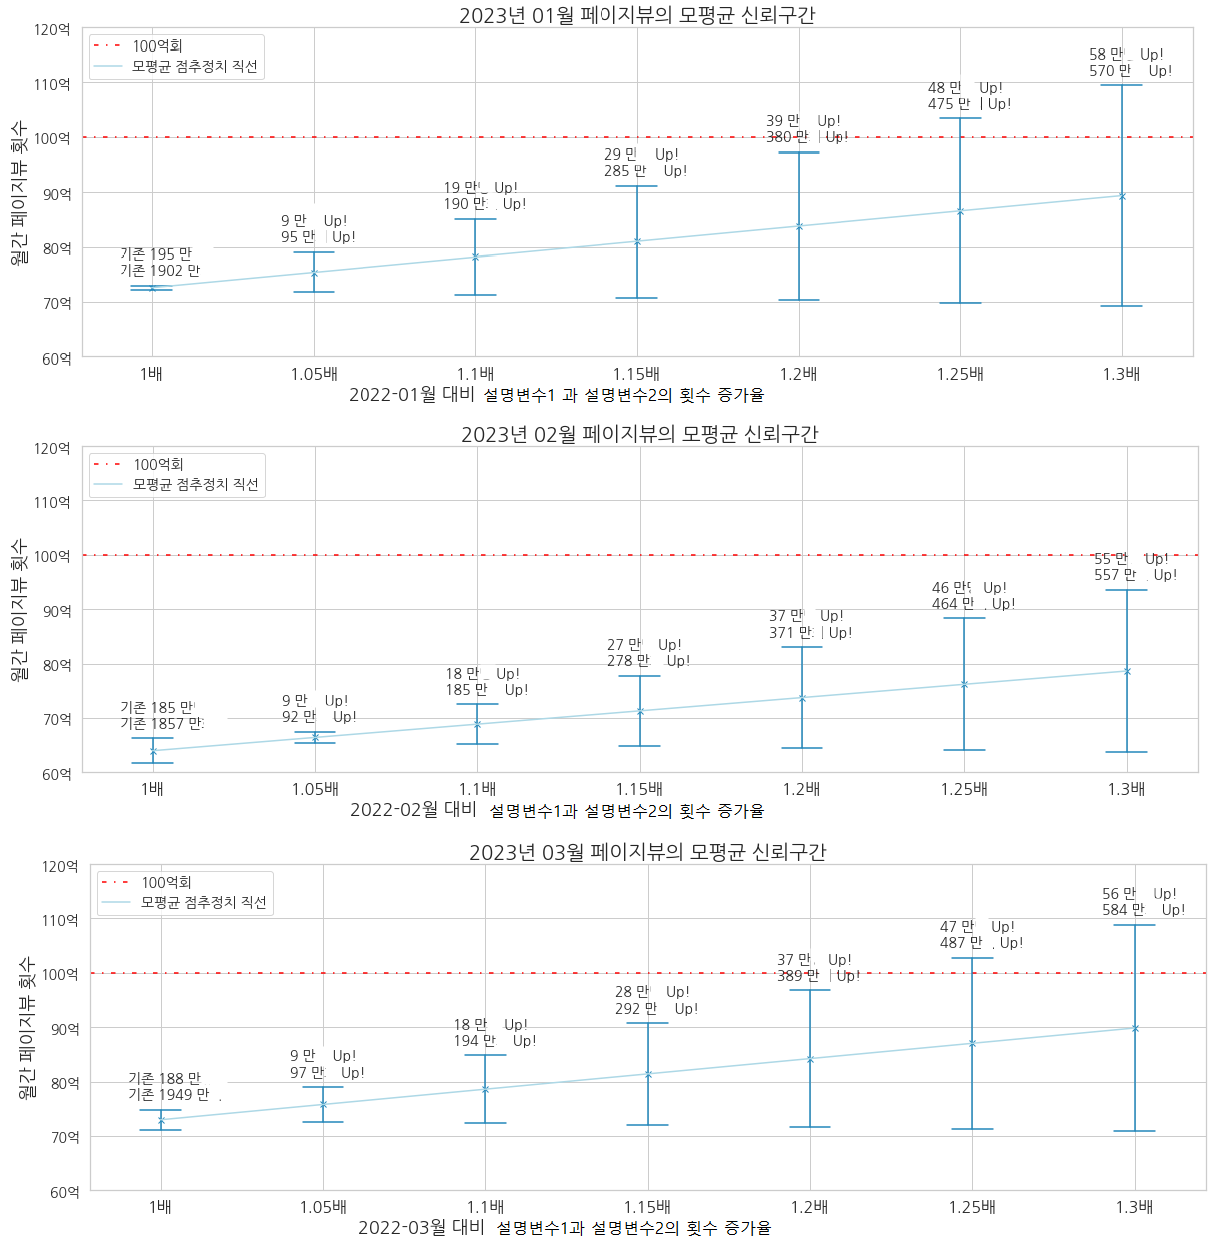